In [8]:
# Part 6
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, FloatType, StringType

# Initialize Spark session
spark = SparkSession.builder.appName("Complete Decision Tree Regression Analysis").getOrCreate()

# Load data
file = "DT.csv"
dt_df = spark.read.csv(file, header=True, inferSchema=True)

# Prepare features and labels
feature_columns = [c for c in dt_df.columns if c != 'yield']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(dt_df).select(col("features"), col("yield").alias("label"))

# Split the dataset into training set and test set
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Initialize and train the decision tree regression model
tree_model = DecisionTreeRegressor(featuresCol="features", labelCol="label", seed=42)
model = tree_model.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error of the model: {mse}")

# Calculate the Pearson correlation coefficient between the actual and predicted values
correlation = predictions.stat.corr("prediction", "label")
print("Linear Correlation (Pearson):", correlation)

# Calculate Minimum and Maximum Error
predictions = predictions.withColumn("Error", col("label") - col("prediction"))
min_error = predictions.select("Error").rdd.min()[0]
max_error = predictions.select("Error").rdd.max()[0]
print("Minimum Error:", min_error)
print("Maximum Error:", max_error)

# Calculate and print Mean Error
mean_error = predictions.select("Error").rdd.map(lambda x: x[0]).mean()
print(f"Mean Error of the model: {mean_error}")

# Retrieve feature importances from the trained model and handle types
feature_importances = model.featureImportances
importances_list = [
    (feature_columns[i], float(feature_importances[i]))  # Convert numpy floats to Python floats
    for i in range(len(feature_columns)) if feature_importances[i] > 0
]

# Define schema for the DataFrame
schema = StructType([
    StructField("Feature", StringType(), True),
    StructField("Importance", FloatType(), True)
])

# Create DataFrame from the list of tuples with the specified schema
feature_importance_df = spark.createDataFrame(importances_list, schema)
feature_importance_df = feature_importance_df.orderBy("Importance", ascending=False)

# Show the feature importances
feature_importance_df.show()

# Stop Spark session
spark.stop()



Mean Squared Error of the model: 365359.462986872
Linear Correlation (Pearson): 0.8927320690122557
Minimum Error: -1572.202608624999
Maximum Error: 1313.1619159393977
Mean Error of the model: 9.578491877463737
+-----------+----------+
|    Feature|Importance|
+-----------+----------+
|RainingDays|0.36617804|
|  clonesize|0.28986537|
|CEII_binned|0.21137337|
|   honeybee|0.13258322|
+-----------+----------+



Root Mean Squared Error (RMSE) on test data: 619.477896444302
Root Mean Squared Error (RMSE) on train data: 642.0508958688016
Testing Data Metrics:
Minimum Error: -1430.0485883719366
Maximum Error: 1548.3157666839224
Mean Error: -3.7258847794196375
Mean Absolute Error (MAE): 490.9816523277755
Pearson Correlation Coefficient: 0.8926977617007921

Training Data Metrics:
Minimum Error: -3163.895592471542
Maximum Error: 2774.201630528458
Mean Error: -1.3998766104684224
Mean Absolute Error (MAE): 507.3660643352398
Pearson Correlation Coefficient: 0.8864916860336395


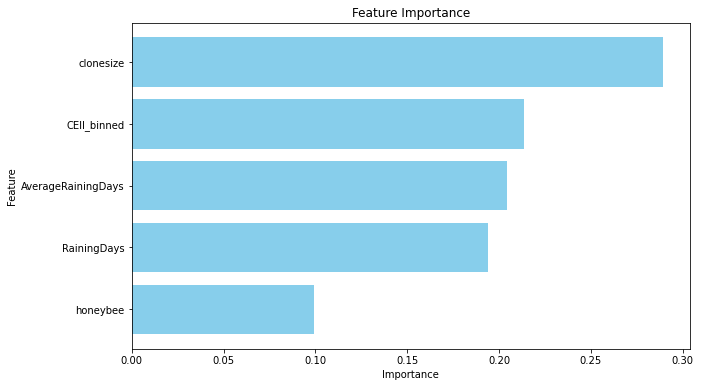

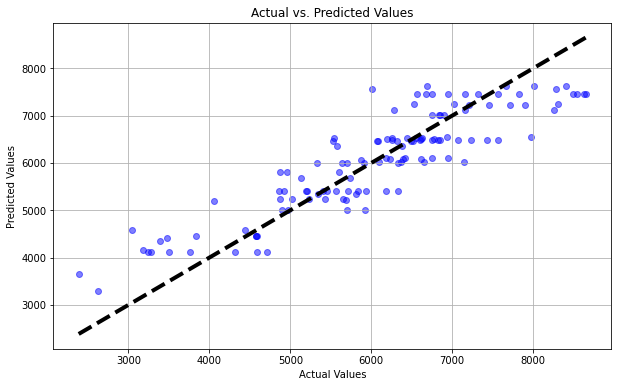

In [2]:
#Part 7,8
# Random forest regression

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
import matplotlib.pyplot as plt


# Initialize Spark session
spark = SparkSession.builder.appName("Random Forest Regression with Detailed Metrics").getOrCreate()

# Load data
file = "DT.csv"
df = spark.read.csv(file, header=True, inferSchema=True)

# Prepare features and labels
feature_columns = [c for c in df.columns if c != 'yield']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df).select(col("features"), col("yield").alias("label"))

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Initialize and train the RandomForest model
rf = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=100, maxDepth=5, seed=42)
model = rf.fit(train_data)

# Predictions on test data
test_predictions = model.transform(test_data)

# Predictions on training data for comparison
train_predictions = model.transform(train_data)


# Evaluate the model with RMSE
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
test_rmse = evaluator.evaluate(test_predictions)
train_rmse = evaluator.evaluate(train_predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {test_rmse}")
print(f"Root Mean Squared Error (RMSE) on train data: {train_rmse}")

# Calculate Mean Absolute Error (MAE)
test_mae_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
test_mae = test_mae_evaluator.evaluate(test_predictions)
train_mae_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
train_mae = train_mae_evaluator.evaluate(train_predictions)

# Calculate Pearson Correlation Coefficient
test_correlation = test_predictions.stat.corr("prediction", "label")
train_correlation = train_predictions.stat.corr("prediction", "label")

# Calculate additional error metrics for test and train data
def calculate_errors(predictions):
    predictions = predictions.withColumn("Error", col("prediction") - col("label"))
    min_error = predictions.agg({"Error": "min"}).collect()[0][0]
    max_error = predictions.agg({"Error": "max"}).collect()[0][0]
    mean_error = predictions.agg({"Error": "mean"}).collect()[0][0]
    return min_error, max_error, mean_error

test_min_error, test_max_error, test_mean_error = calculate_errors(test_predictions)
train_min_error, train_max_error, train_mean_error = calculate_errors(train_predictions)

# Print out the results
print("Testing Data Metrics:")
print("Minimum Error:", test_min_error)
print("Maximum Error:", test_max_error)
print("Mean Error:", test_mean_error)
print("Mean Absolute Error (MAE):", test_mae)
print("Pearson Correlation Coefficient:", test_correlation)

print("\nTraining Data Metrics:")
print("Minimum Error:", train_min_error)
print("Maximum Error:", train_max_error)
print("Mean Error:", train_mean_error)
print("Mean Absolute Error (MAE):", train_mae)
print("Pearson Correlation Coefficient:", train_correlation)



import matplotlib.pyplot as plt

# Assuming 'model' is your trained RandomForest model from PySpark
feature_importances = model.featureImportances
features = feature_columns
importances = [(feature, float(feature_importances[idx])) for idx, feature in enumerate(features) if feature_importances[idx] > 0]

# If the data is small enough to fit comfortably into your driver's memory
importance_df = spark.createDataFrame(importances, ["Feature", "Importance"]).orderBy("Importance", ascending=False).toPandas()

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert axis to have the most important at the top
plt.show()


import matplotlib.pyplot as plt

# Collect actual and predicted values from the test data predictions
# Ensure the data size is reasonable to collect to the driver node
actual_vs_predicted = test_predictions.select("label", "prediction").collect()

# Extract actual and predicted values for plotting
actual_values = [row['label'] for row in actual_vs_predicted]
predicted_values = [row['prediction'] for row in actual_vs_predicted]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, alpha=0.5, color='blue')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], 'k--', lw=4)  # Line y=x for reference
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()






spark.stop()



In [11]:
# The linear regression model

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, lit
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder.appName("Linear Regression Analysis").getOrCreate()

# Load data
file = "DT.csv"
df = spark.read.csv(file, header=True, inferSchema=True)

# Prepare features and labels
feature_columns = [c for c in df.columns if c != 'yield']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df).select(col("features"), col("yield").alias("label"))

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Initialize and train the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="label",regParam=0.3, elasticNetParam=0.8)
model = lr.fit(train_data)

# Predictions on test and training data
train_predictions = model.transform(train_data)
test_predictions = model.transform(test_data)

# Evaluate the model with RMSE
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
train_rmse = evaluator.evaluate(train_predictions)
test_rmse = evaluator.evaluate(test_predictions)
from pyspark.sql.functions import mean, min, max, abs as abs_
from pyspark.mllib.stat import Statistics

# Function to calculate metrics from predictions DataFrame
def calculate_metrics(predictions):
    predictions = predictions.withColumn("Error", col("label") - col("prediction"))
    min_error = predictions.select(min(abs_("Error")).alias("min_error")).collect()[0]['min_error']
    max_error = predictions.select(max(abs_("Error")).alias("max_error")).collect()[0]['max_error']
    mean_error = predictions.select(mean("Error").alias("mean_error")).collect()[0]['mean_error']
    mae = predictions.select(mean(abs_("Error")).alias("mae")).collect()[0]['mae']
    # Pearson correlation requires rdd, calculate it on label vs prediction
    correlation = Statistics.corr(predictions.select("label").rdd.map(lambda x: x[0]), 
                                  predictions.select("prediction").rdd.map(lambda x: x[0]), 
                                  method="pearson")
    return min_error, max_error, mean_error, mae, correlation

# Calculate metrics for training and testing data
train_metrics = calculate_metrics(train_predictions)
test_metrics = calculate_metrics(test_predictions)

# Print out the results for training data
print("Training Data Metrics:")
print(f"Minimum Error: {train_metrics[0]}")
print(f"Maximum Error: {train_metrics[1]}")
print(f"Mean Error: {train_metrics[2]}")
print(f"Mean Absolute Error (MAE): {train_metrics[3]}")
print(f"Pearson Correlation Coefficient: {train_metrics[4]}")

# Print out the results for testing data
print("\nTesting Data Metrics:")
print(f"Minimum Error: {test_metrics[0]}")
print(f"Maximum Error: {test_metrics[1]}")
print(f"Mean Error: {test_metrics[2]}")
print(f"Mean Absolute Error (MAE): {test_metrics[3]}")
print(f"Pearson Correlation Coefficient: {test_metrics[4]}")

# Print evaluation metrics
print("Training Data RMSE: {:.3f}".format(train_rmse))
print("Testing Data RMSE: {:.3f}".format(test_rmse))

# Calculate residuals
train_predictions = train_predictions.withColumn("residuals", col("prediction") - col("label"))
test_predictions = test_predictions.withColumn("residuals", col("prediction") - col("label"))

# Plot residuals
train_residuals = train_predictions.select("prediction", "residuals").collect()
test_residuals = test_predictions.select("prediction", "residuals").collect()





coefficients = model.coefficients  # This gets the coefficients of the features
feature_names = feature_columns   # This should match the features inputted to the model

# Associate coefficients with feature names
feature_importance = [(feature, abs(coef)) for feature, coef in zip(feature_names, coefficients)]

# Sort features by importance
feature_importance_sorted = sorted(feature_importance, key=lambda x: x[1], reverse=True)

# Unzip for plotting
features, importances = zip(*feature_importance_sorted)




24/05/17 10:28:39 WARN Instrumentation: [993f818f] regParam is zero, which might cause numerical instability and overfitting.


Training Data Metrics:
Minimum Error: 2.2899487532858984
Maximum Error: 4277.951908874853
Mean Error: 1.2573450873285007e-11
Mean Absolute Error (MAE): 646.7446459523316
Pearson Correlation Coefficient: 0.7941607929638773

Testing Data Metrics:
Minimum Error: 2.2634884530848467
Maximum Error: 2444.4637878748526
Mean Error: 19.164523414611633
Mean Absolute Error (MAE): 621.8159712052561
Pearson Correlation Coefficient: 0.8189082286456308
Training Data RMSE: 825.821
Testing Data RMSE: 769.739


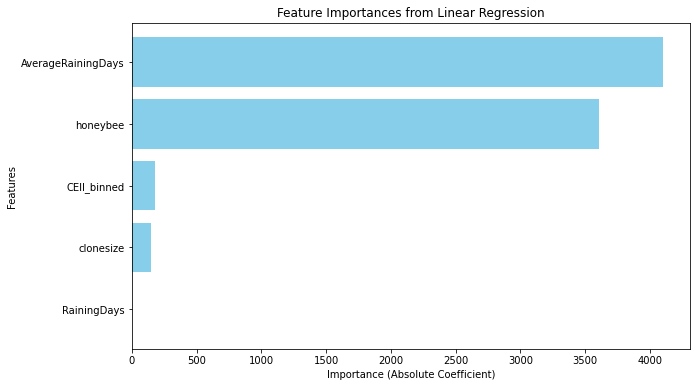

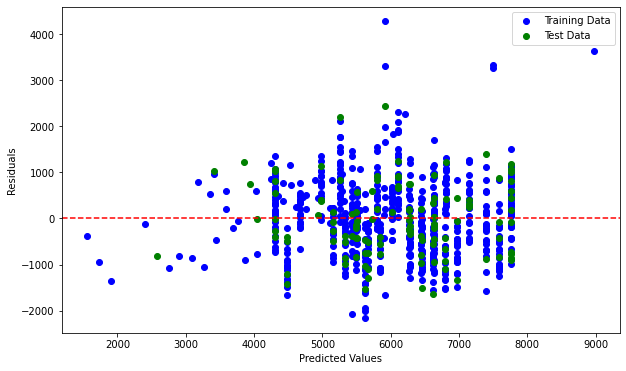

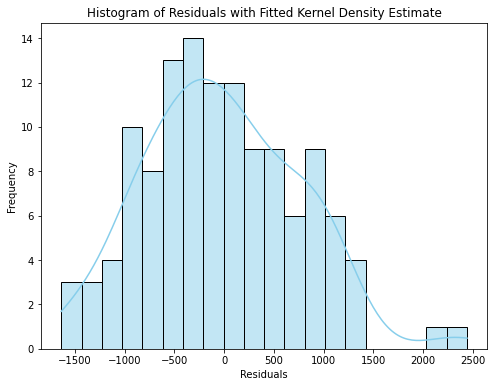

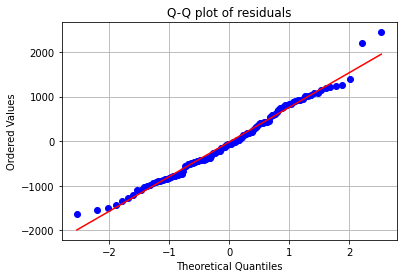

In [12]:
# The visualization of linear regression
import matplotlib.pyplot as plt
from scipy import stats

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance (Absolute Coefficient)')
plt.ylabel('Features')
plt.title('Feature Importances from Linear Regression')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter([x['prediction'] for x in train_residuals], [x['residuals'] for x in train_residuals], color='blue', label='Training Data')
plt.scatter([x['prediction'] for x in test_residuals], [x['residuals'] for x in test_residuals], color='green', label='Test Data')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Collect data and plot histogram of residuals using seaborn
all_residuals = [x['residuals'] for x in test_residuals]  # combining test residuals
plt.figure(figsize=(8, 6))
sns.histplot(all_residuals, kde=True, color='skyblue', bins=20)
plt.title('Histogram of Residuals with Fitted Kernel Density Estimate')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()



# Assuming 'test_predictions' already has the 'residuals' column calculated
# Collect residuals data for plotting (ensure manageable dataset size)
residuals_list = test_predictions.select("residuals").rdd.flatMap(lambda x: x).collect()

# Generate a Q-Q plot using scipy's probplot
stats.probplot(residuals_list, dist="norm", plot=plt)
plt.title('Q-Q plot of residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.grid(True)
plt.show()


